In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from IPython.display import display_markdown, display_html
import time
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MeanShift, SpectralClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, make_scorer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [2]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2?family=DM+Sans:ital,opsz,wght@0,9..40,100..1000;1,9..40,100..1000&display=swap');
div.text_cell {font-family : DM Sans, sans-serif !important;}
pre {font-family : DM Sans, sans-serif !important;}
</style>

# **Clustering and Model Comparison Template** 
This Notebook compares the performance of different types of clustering models on a dataset provided by the user. It is meant to assist in the model selection process, helping users discern the most suitible clustering technique for their dataset. Users should store data in the data directory.
### **Clustering**

### Load In Data and Select Columns to Drop

In [3]:
DATA_FILE_NAME: str = "clustering_customer_data.csv"
COLUMNS_TO_DROP: list[str] = ["CUST_ID"]  # We don't need the customer ID for clustering

In [4]:
def load_data(file_name: str = DATA_FILE_NAME, dropped_columns = COLUMNS_TO_DROP) -> pd.DataFrame:
    """
    Loads in user's input file as a pandas DataFrame.
    
    Args:
        file_name (str): Name of file containing data for clustering
    Returns:
        pd.DataFrame: Dataframe of feature variable values for all data entries
    """
    file_name = "data/" + file_name
    file_extension = file_name.split(".")[-1]

    if file_extension == "csv":
        df = pd.read_csv(file_name)
    elif file_extension in ["xls", "xlsx"]:
        df = pd.read_excel(file_name)
    elif file_extension == "json":
        df = pd.read_json(file_name)
    else:
        raise ValueError("Unsupported file format. Please upload a CSV, Excel, or JSON file.")
    
    df.drop_duplicates(inplace = True)
    df.drop(columns = dropped_columns, inplace = True)
    
    return df

data_df = load_data()

### Setup Data Preprocessing

In [5]:
def preprocess_data(df: pd.DataFrame) -> np.ndarray:
    """
    Preprocesses the data for clustering.
    
    Args:
        df (pd.DataFrame): Input dataframe
    Returns:
        np.ndarray: Preprocessed data ready for clustering
    """
    # Handle missing values
    df = df.dropna()
    
    # Scale the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    return scaled_data

X = preprocess_data(data_df)

### Load Models and Hyperparameters

In [27]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

def kmeans_clustering(X: np.ndarray) -> dict:
    param_grid = {
        'n_clusters': [3, 5, 7, 9],
        'init': ['k-means++', 'random'],
        'max_iter': [200, 300]
    }
    kmeans = KMeans(random_state = 42)
    grid_search = GridSearchCV(kmeans, param_grid, cv = 5, scoring = make_scorer(silhouette_scorer), n_jobs = -1)
    grid_search.fit(X)
    
    best_kmeans = grid_search.best_estimator_
    labels = best_kmeans.labels_
    
    return {
        'model': best_kmeans,
        'labels': labels,
        'best_params': grid_search.best_params_
    }

def dbscan_clustering(X: np.ndarray) -> dict:
    param_grid = {
        'eps': [0.3, 0.5, 0.7],
        'min_samples': [3, 5, 7]
    }
    dbscan = DBSCAN()
    grid_search = GridSearchCV(dbscan, param_grid, cv = 5, scoring = make_scorer(silhouette_scorer), n_jobs = -1)
    grid_search.fit(X)
    
    best_dbscan = grid_search.best_estimator_
    labels = best_dbscan.fit_predict(X)
    
    return {
        'model': best_dbscan,
        'labels': labels,
        'best_params': grid_search.best_params_
    }

def gaussian_mixture_clustering(X: np.ndarray) -> dict:
    param_grid = {
        'n_components': [3, 5, 7],
        'covariance_type': ['full', 'tied', 'diag', 'spherical']
    }
    gmm = GaussianMixture(random_state=42)
    grid_search = GridSearchCV(gmm, param_grid, cv = 5, scoring = make_scorer(silhouette_scorer), n_jobs = -1)
    grid_search.fit(X)
    
    best_gmm = grid_search.best_estimator_
    labels = best_gmm.predict(X)
    
    return {
        'model': best_gmm,
        'labels': labels,
        'best_params': grid_search.best_params_
    }

def hierarchical_clustering(X: np.ndarray) -> dict:
    # Hierarchical clustering doesn't have parameters to optimize in scikit-learn
    linkage_matrix = linkage(X, method='ward')
    
    return {
        'model': linkage_matrix,
        'labels': None,
        'best_params': {'method': 'ward'}
    }

def mean_shift_clustering(X: np.ndarray) -> dict:
    # Mean Shift doesn't have many parameters to optimize, but we can try different bandwidths
    bandwidths = [estimate_bandwidth(X, quantile = q) for q in [0.2, 0.3, 0.4]]
    
    best_score = -np.inf
    best_ms = None
    best_labels = None
    best_bandwidth = None
    
    for bandwidth in bandwidths:
        ms = MeanShift(bandwidth = bandwidth)
        labels = ms.fit_predict(X)
        score = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else -np.inf
        
        if score > best_score:
            best_score = score
            best_ms = ms
            best_labels = labels
            best_bandwidth = bandwidth
    
    return {
        'model': best_ms,
        'labels': best_labels,
        'best_params': {'bandwidth': best_bandwidth}
    }

def spectral_clustering(X: np.ndarray) -> dict:
    param_grid = {
        'n_clusters': [3, 5, 7],
        'assign_labels': ['kmeans', 'discretize'],
        'affinity': ['rbf', 'nearest_neighbors']
    }
    sc = SpectralClustering(random_state=42)
    grid_search = GridSearchCV(sc, param_grid, cv = 5, scoring = make_scorer(silhouette_scorer), n_jobs = -1)
    grid_search.fit(X)
    
    best_sc = grid_search.best_estimator_
    labels = best_sc.fit_predict(X)
    
    return {
        'model': best_sc,
        'labels': labels,
        'best_params': grid_search.best_params_
    }

clustering_models = {
    'K-Means': kmeans_clustering,
    'DBSCAN': dbscan_clustering,
    'Gaussian Mixture': gaussian_mixture_clustering,
    'Hierarchical': hierarchical_clustering,
    'Mean Shift': mean_shift_clustering
    #'Spectral': spectral_clustering
}

### Train and Evaluate Models

In [28]:
def evaluate_clustering(X: np.ndarray, labels: np.ndarray) -> dict:
    """
    Evaluates clustering results using various metrics.
    
    Args:
        X (np.ndarray): Input data
        labels (np.ndarray): Cluster labels
    Returns:
        dict: Dictionary of evaluation metrics
    """
    if labels is None or len(np.unique(labels)) <= 1:
        return {
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None
        }
    
    return {
        'silhouette': silhouette_score(X, labels),
        'calinski_harabasz': calinski_harabasz_score(X, labels),
        'davies_bouldin': davies_bouldin_score(X, labels)
    }

results = {}

for model_name, clustering_func in clustering_models.items():
    print(f"Clustering with {model_name}")
    
    start_time = time.time()
    model_results = clustering_func(X)
    end_time = time.time()
    
    results[model_name] = {
        'model': model_results['model'],
        'labels': model_results['labels'],
        'best_params': model_results['best_params'],
        'time': end_time - start_time
    }
    
    if results[model_name]['labels'] is not None:
        results[model_name]['evaluation'] = evaluate_clustering(X, results[model_name]['labels'])
        print(f"Number of clusters: {len(np.unique(results[model_name]['labels']))}")
        print(f"Evaluation metrics: {results[model_name]['evaluation']}")
    
    print(f"Best parameters: {results[model_name]['best_params']}")
    print(f"Time taken: {results[model_name]['time']:.2f} seconds")
    print()

Clustering with K-Means


/Users/polydeltaintern/anaconda3/envs/regression-comparison-temp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/polydeltaintern/anaconda3/envs/regression-comparison-temp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/polydeltaintern/anaconda3/envs/regression-comparison-temp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/polydeltaintern/anaconda3/e

Number of clusters: 3
Evaluation metrics: {'silhouette': 0.24709726016009056, 'calinski_harabasz': 1546.5282196877843, 'davies_bouldin': 1.6054428218015637}
Best parameters: {'init': 'k-means++', 'max_iter': 200, 'n_clusters': 3}
Time taken: 1.62 seconds

Clustering with DBSCAN


/Users/polydeltaintern/anaconda3/envs/regression-comparison-temp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/polydeltaintern/anaconda3/envs/regression-comparison-temp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/polydeltaintern/anaconda3/envs/regression-comparison-temp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/polydeltaintern/anaconda3/e

Number of clusters: 111
Evaluation metrics: {'silhouette': -0.47800400639962515, 'calinski_harabasz': 5.094071456412124, 'davies_bouldin': 1.3776831176681423}
Best parameters: {'eps': 0.3, 'min_samples': 3}
Time taken: 1.78 seconds

Clustering with Gaussian Mixture


/Users/polydeltaintern/anaconda3/envs/regression-comparison-temp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/polydeltaintern/anaconda3/envs/regression-comparison-temp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/polydeltaintern/anaconda3/envs/regression-comparison-temp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/polydeltaintern/anaconda3/e

Number of clusters: 3
Evaluation metrics: {'silhouette': 0.11512267967773161, 'calinski_harabasz': 887.5586013813892, 'davies_bouldin': 2.6276790687793006}
Best parameters: {'covariance_type': 'full', 'n_components': 3}
Time taken: 3.01 seconds

Clustering with Hierarchical
Best parameters: {'method': 'ward'}
Time taken: 1.42 seconds

Clustering with Mean Shift
Number of clusters: 58
Evaluation metrics: {'silhouette': 0.3453011424044342, 'calinski_harabasz': 72.18889804130328, 'davies_bouldin': 0.8107342274028372}
Best parameters: {'bandwidth': 4.495984720224732}
Time taken: 114.78 seconds



### Display Functions

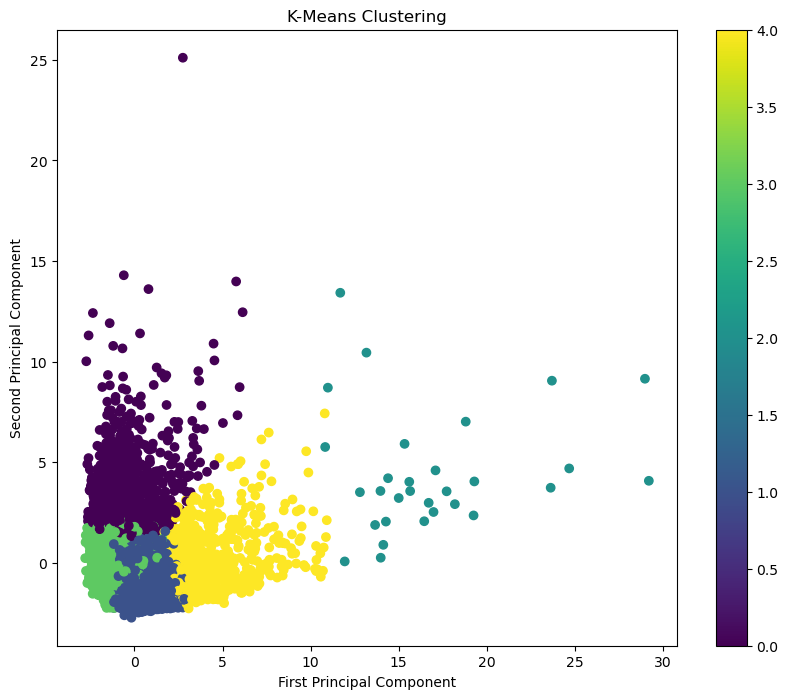

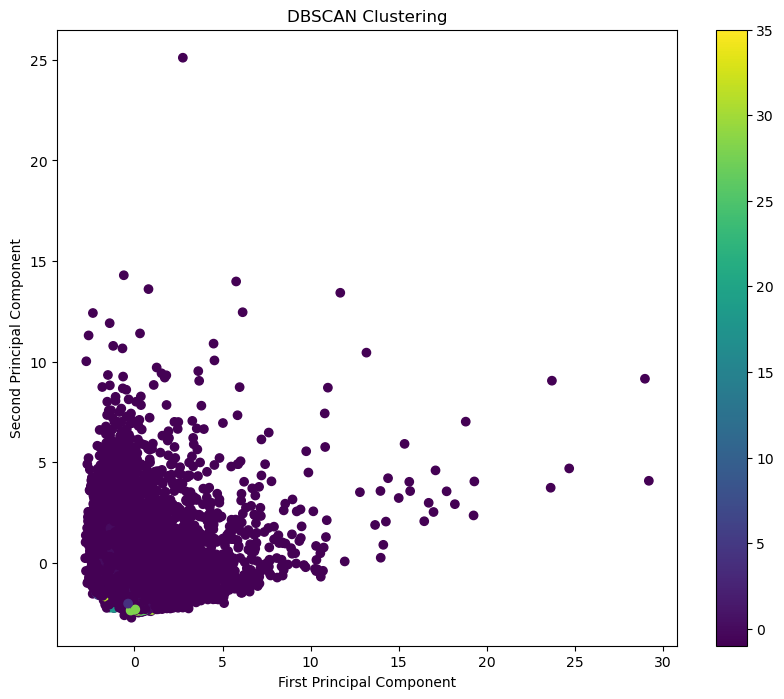

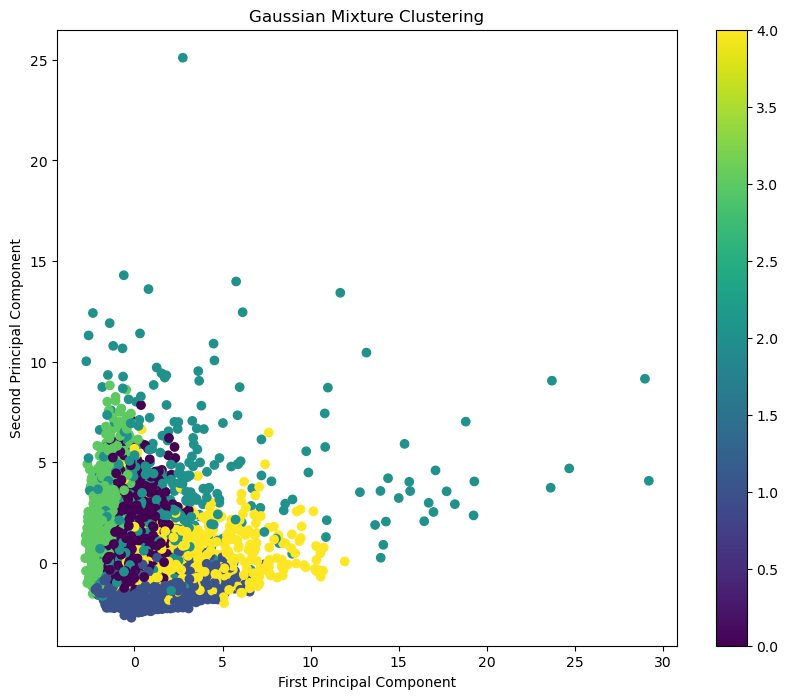

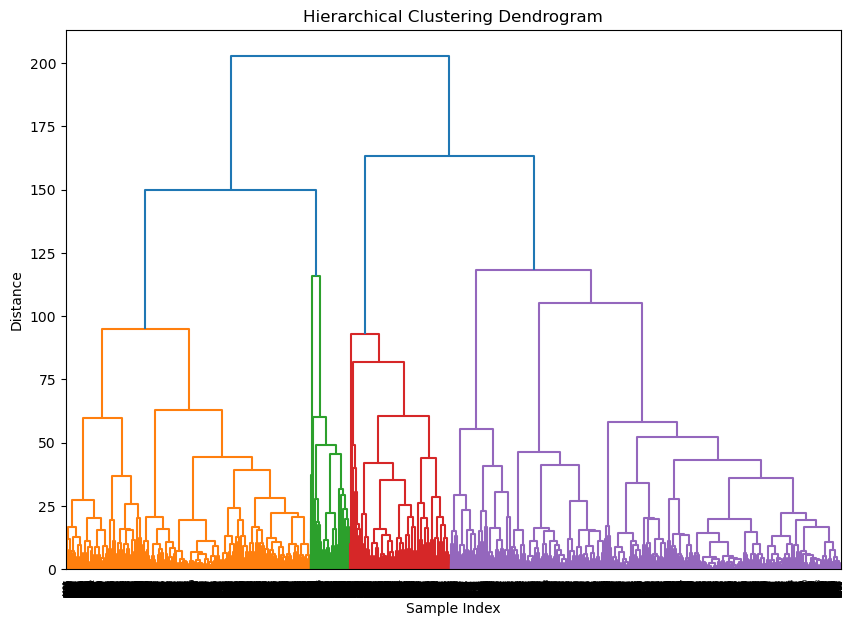

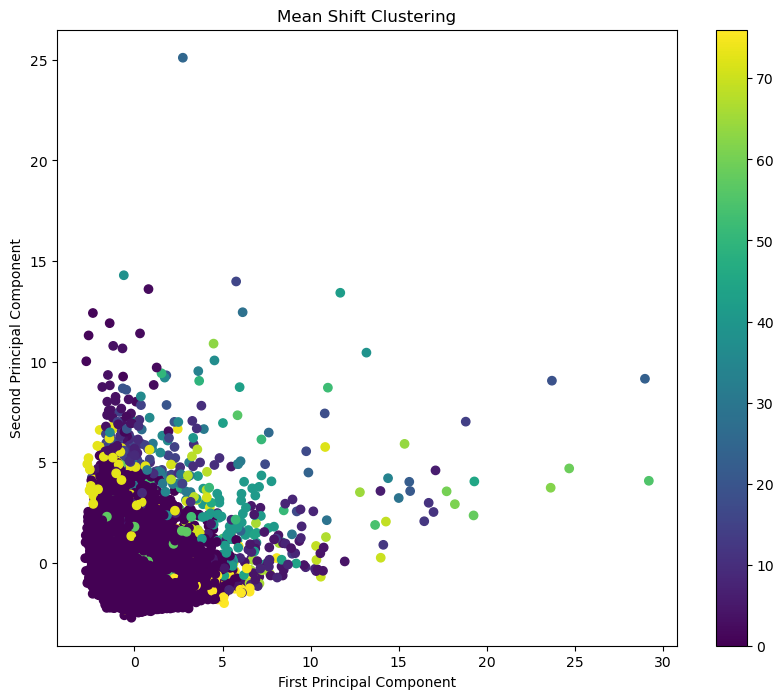

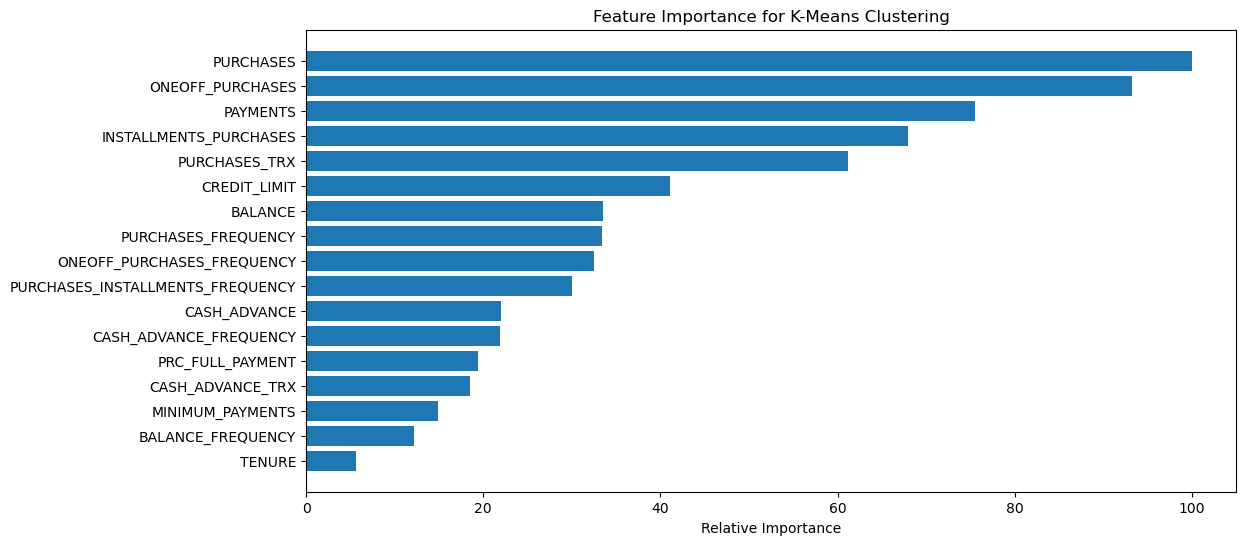

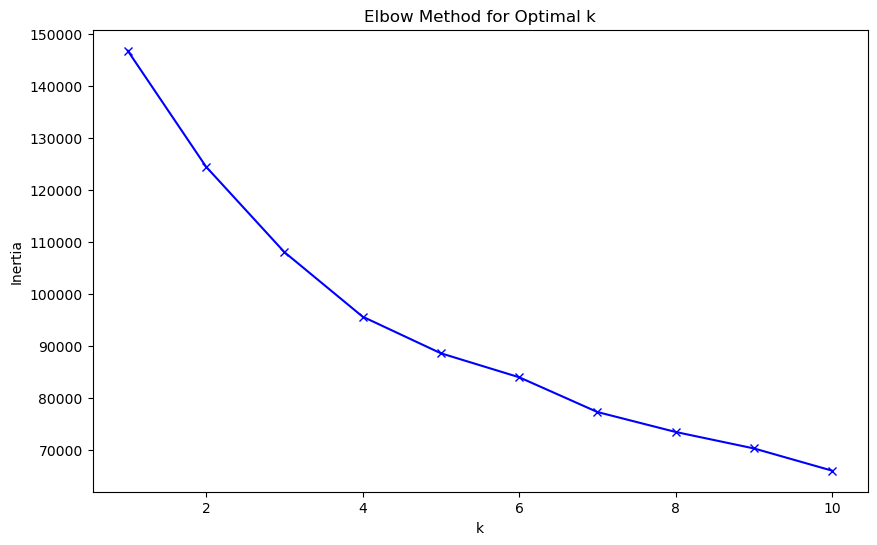

In [12]:
def plot_clusters_2d(X: np.ndarray, labels: np.ndarray, title: str):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c = labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

def plot_dendrogram(linkage_matrix: np.ndarray):
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

for model_name, result in results.items():
    if model_name != 'Hierarchical':
        plot_clusters_2d(X, result['labels'], f'{model_name} Clustering')
    else:
        plot_dendrogram(result['model'])

# Feature importance for K-Means
kmeans_model = results['K-Means']['model']
feature_importance = np.abs(kmeans_model.cluster_centers_).mean(axis=0)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, data_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance for K-Means Clustering')
plt.show()

In [13]:
display(md("# Clustering Results Summary"))

for model_name, result in results.items():
    display(md(f"## {model_name}"))
    
    if 'evaluation' in result:
        display(md("### Evaluation Metrics"))
        for metric, value in result['evaluation'].items():
            display(md(f"- {metric.capitalize()}: {value:.4f}"))
    
    display(md(f"### Time Taken: {result['time']:.2f} seconds"))
    
    if model_name != 'Hierarchical':
        display(md(f"### Number of Clusters: {len(np.unique(result['labels']))}"))
    
    print()

# Identify the best model based on silhouette score
best_model = max(
    [model for model in results.items() if 'evaluation' in model[1]],
    key=lambda x: x[1]['evaluation']['silhouette']
)

display(md(f"# Best Performing Model: {best_model[0]}"))
display(md(f"Silhouette Score: {best_model[1]['evaluation']['silhouette']:.4}"))

# Clustering Results Summary

## K-Means

### Evaluation Metrics

- Silhouette: 0.1903

- Calinski_harabasz: 1417.0975

- Davies_bouldin: 1.5000

### Time Taken: 0.21 seconds

### Number of Clusters: 5

## DBSCAN

### Evaluation Metrics

- Silhouette: -0.4651

- Calinski_harabasz: 19.2736

- Davies_bouldin: 1.3843

### Time Taken: 0.13 seconds

### Number of Clusters: 37

## Gaussian Mixture

### Evaluation Metrics

- Silhouette: 0.0677

- Calinski_harabasz: 592.4061

- Davies_bouldin: 2.8942

### Time Taken: 4.08 seconds

### Number of Clusters: 5

## Hierarchical

### Time Taken: 1.64 seconds

## Mean Shift

### Evaluation Metrics

- Silhouette: 0.2725

- Calinski_harabasz: 66.8447

- Davies_bouldin: 0.8773

### Time Taken: 47.69 seconds

### Number of Clusters: 77

# Best Performing Model: Mean Shift

Silhouette Score: 0.2725

In [33]:
display_markdown(md("# Clustering Results Summary"))

for model_name, result in results.items():
    display_markdown(md(f"## {model_name}"))
    
    display_markdown(md("### Best Parameters"))
    for param, value in result['best_params'].items():
        display_markdown(md(f"- {param}: {value}"))
    
    if 'evaluation' in result:
        display_markdown(md("### Evaluation Metrics"))
        for metric, value in result['evaluation'].items():
            display_markdown(md(f"- {metric.capitalize()}: {value:.4f}"))
    
    display_markdown(md(f"### Time Taken: {result['time']:.2f} seconds"))
    
    if result['labels'] is not None:
        display_markdown(md(f"### Number of Clusters: {len(np.unique(result['labels']))}"))
    
    print()

# Identify the best model based on silhouette score
best_model = max(
    [model for model in results.items() if 'evaluation' in model[1] and model[1]['evaluation']['silhouette'] is not None],
    key=lambda x: x[1]['evaluation']['silhouette']
)

display_markdown(md(f"# Best Performing Model: {best_model[0]}"))
display_markdown(md(f"Silhouette Score: {best_model[1]['evaluation']['silhouette']:.4f}"))
display_markdown(md("### Best Parameters"))
for param, value in best_model[1]['best_params'].items():
    display_markdown(md(f"- {param}: {value}"))

# Clustering Results Summary

## K-Means

### Best Parameters

- init: k-means++

- max_iter: 200

- n_clusters: 3

### Evaluation Metrics

- Silhouette: 0.2471

- Calinski_harabasz: 1546.5282

- Davies_bouldin: 1.6054

### Time Taken: 1.62 seconds

### Number of Clusters: 3

## DBSCAN

### Best Parameters

- eps: 0.3

- min_samples: 3

### Evaluation Metrics

- Silhouette: -0.4780

- Calinski_harabasz: 5.0941

- Davies_bouldin: 1.3777

### Time Taken: 1.78 seconds

### Number of Clusters: 111

## Gaussian Mixture

### Best Parameters

- covariance_type: full

- n_components: 3

### Evaluation Metrics

- Silhouette: 0.1151

- Calinski_harabasz: 887.5586

- Davies_bouldin: 2.6277

### Time Taken: 3.01 seconds

### Number of Clusters: 3

## Hierarchical

### Best Parameters

- method: ward

### Time Taken: 1.42 seconds

## Mean Shift

### Best Parameters

- bandwidth: 4.495984720224732

### Evaluation Metrics

- Silhouette: 0.3453

- Calinski_harabasz: 72.1889

- Davies_bouldin: 0.8107

### Time Taken: 114.78 seconds

### Number of Clusters: 58

# Best Performing Model: Mean Shift

Silhouette Score: 0.3453

### Best Parameters

- bandwidth: 4.495984720224732